feature engineering은 모델의 성능을 향상시키는 매우 중요한 단계입니다. 그러나 feature가 너무 많으면 overfitting의 위험이 있고, 모델이 이상적인 방향으로 학습을 하지 않을 위험이 있습니다. 실제로도 feature가 너무 많은 경우 원래 모델보다 성능이 안좋게 나오는 경우가 많습니다. 따라서 feature selection을 해야 합니다.

저는 feature selection으로 크게 두 가지 방법을 사용해봤습니다. 첫째, feature을 하나씩 추가해보고 모델의 성능을 향상시키면 채택하고 성능이 나빠지면 버리는 방법. 둘째, 도움이 될 만한 feature들을 모두 추가해본 뒤, feature selection 테크닉들을 통해 중요한 feature만 뽑아내는 방법. 이 커널에서는 두 번째 방법을 다뤄보겠습니다. 

여러 feature들 중 일부만 선택하는 방법은 당연히 모델의 성능에 대한 그 feature의 중요도에 따라서이겠죠. feature importance를 얻기 위해서는 기본적으로 gbm 모델들에서 제공되는 feature_importances_ attribute을 사용할 수도 있겠지만, 이 외에도 permutation importance, shap 등을 사용할 수도 있습니다. 또한 기본 모델에 feature importance를 한번만 알아봐서 top n개의 feature만 선택하는 방법(one-shot)도 있을 수 있고, rfe(recurrent feature elimination)로 모델을 학습시키고 feature을 줄여나가는 것을 반복할 수도 있습니다. 마지막으로 boruta라는 방법을 이용해 자동으로 feature을 선택할 수도 있습니다.

정리하자면 이 커널에서는 다음과 같은 실험을 하겠습니다.

1. [기본 feature_importances_](https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMRegressor.feature_importances_)
    1. one-shot
    2. rfe
2. [permutation importance](https://www.kaggle.com/dansbecker/permutation-importance)
    1. one-shot
    2. rfe
3. [shap](https://github.com/slundberg/shap)
    1. one-shot
    2. rfe
4. [boruta](https://www.kaggle.com/tilii7/boruta-feature-elimination)

In [1]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import warnings
import gc
warnings.filterwarnings("ignore")

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [3]:
data = pd.read_csv('./input/train.csv', index_col='id')
test = pd.read_csv('./input/test.csv', index_col='id')
df = pd.concat([data, test])

# Feature Engineering

In [4]:
today = pd.to_datetime('2016-01-01')
    
# datetime features
df['was_renovated'] = (df['yr_renovated'] != 0).astype('uint8')
not_renovated = df[df['was_renovated'] == 0].index
df.loc[not_renovated, 'yr_renovated'] = df.loc[not_renovated, 'yr_built']
df['date'] = pd.to_datetime(df['date'].str[:8])
df['yr_built'] = pd.to_datetime({'year': df['yr_built'], 'month': [1]*len(df), 'day': [1]*len(df)})
df['yr_renovated'] = pd.to_datetime({'year': df['yr_renovated'], 'month': [1]*len(df), 'day': [1]*len(df)}, errors='coerce')
df['today-D-date'] = (today - df['date']).dt.days
df['today-D-yr_renovated'] = (today - df['yr_renovated']).dt.days
df['today-D-yr_built'] = (today - df['yr_built']).dt.days
df['date-D-yr_built'] = (df['date'] - df['yr_built']).dt.days
df['yr_renovated-D-yr_built'] = (df['yr_renovated'] - df['yr_built']).dt.days
df = df.drop(['date', 'yr_built', 'yr_renovated'], axis=1)

# feature interactions
df['room_count'] = df['bedrooms'] + df['bathrooms']
df['sqft_living_per_rooms'] = df['sqft_living'] / (df['room_count']+1)
df['sqft_lot_per_rooms'] = df['sqft_lot'] / (df['room_count']+1)
df['room_per_floors'] = df['room_count'] / df['floors']
df['sqft_living_per_floors'] = df['sqft_living'] / df['floors']
df['sqft_lot_per_floors'] = df['sqft_lot'] / df['floors']
df['sqft_living_per_bedrooms'] = df['sqft_living'] / (df['bedrooms']+1)
df['sqft_lot_per_bedrooms'] = df['sqft_lot'] / (df['bedrooms']+1)
df['bedroom_per_floors'] = df['bedrooms'] / df['floors']
df['sqft_lot-D-sqft_living'] = df['sqft_lot'] - df['sqft_living']
df['sqft_lot-R-sqft_living'] = df['sqft_lot'] / df['sqft_living']
df['sqft_living15-D-sqft_living'] = df['sqft_living15'] - df['sqft_living']
df['sqft_living15-R-sqft_living'] = df['sqft_living15'] / df['sqft_living']
df['sqft_lot15-D-sqft_lot'] = df['sqft_lot15'] - df['sqft_lot']
df['sqft_lot15-R-sqft_lot'] = df['sqft_lot15'] / df['sqft_lot']
df['rooms_mul']=df['bedrooms']*df['bathrooms']
df['total_score']=df['condition']+df['grade']+df['view']

# binary features
df['has_basement'] = (df['sqft_basement']>0).astype('uint8')
df['has_attic'] = ((df['floors'] % 1) != 0).astype('uint8')

# one hot encode
df['zipcode'] = df['zipcode'].astype('str')
df = pd.get_dummies(df)

# log transform target
df['price'] = np.log1p(df['price'])

data = df.loc[data.index]
test = df.loc[test.index]

del df; gc.collect();

In [5]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
id,,,,,,,,,,,,,,,,,,,,,
0,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,...,0,0,0,0,0,0,1,0,0,0
1,12.100718,2,1.00,770,10000,1.0,0,0,3,6,...,0,0,0,0,0,0,0,0,0,0
2,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0
3,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
4,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,...,0,0,0,0,0,0,0,0,1,0


# 도움 함수 정의

In [6]:
def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def evaluate(x_data, y_data):
    model = LGBMRegressor(objective='regression', num_iterations=10**5)
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
    val_pred = model.predict(x_val)
    score = rmse_expm1(val_pred, y_val)
    return score

def rfe(x_data, y_data, method, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMRegressor(objective='regression', num_iterations=10**5)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict(x_val)
        score = rmse_expm1(val_pred, y_val)
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

feats = [col for col in data.columns if col != 'price']
len(feats)

110

# Baseline

In [7]:
model = LGBMRegressor(objective='regression', num_iterations=10**5)
x_data = data[feats]
y_data = data['price']
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
val_pred = model.predict(x_val)
score = rmse_expm1(val_pred, y_val)
score

-114196.18786023316

# Basic Feature Importance

### 1. RFE

In [8]:
%%time
basic_archive = rfe(x_data, y_data, 'basic')

110 -114196.18786023316
99 -114151.5472024381
89 -114034.74656724831
80 -113556.50303290032
72 -114080.559224715
64 -112902.92445798447
57 -112926.24283295323
51 -114543.7594796587
45 -115909.96964342736
40 -116453.48053863567
CPU times: user 1min 38s, sys: 824 ms, total: 1min 39s
Wall time: 6.44 s


### 2. One-shot

In [10]:
model.feature_importances_

array([ 22,  67, 228, 120,   8,  33,  39,  60,  75, 195, 130, 587, 496,
       261, 166,   3, 256, 232, 105, 114,  35,  69, 144, 122,  93, 147,
       109, 148, 106,  19,  92, 113, 170, 142, 109, 153,  65, 151,   0,
        11,   6,   0,   2,  29,  13,  17,   0,   0,   8,   1,  17,  13,
         0,   5,   1,  17,   6,   2,   1,   0,   0,  11,   2,   2,  12,
        27,  12,   6,   2,   3,   2,   0,   3,   6,   4,   0,   7,  10,
         0,   0,   0,   8,  11,   7,  15,   0,  24,  15,  22,   6,   2,
         0,   9,  16,   2,   2,   4,   8,  11,   7,   8,   0,   4,  21,
        19,   8,  12,   7,   7,   3], dtype=int32)

In [14]:
len(model.feature_importances_)

110

In [15]:
np.array(feats).shape

(110,)

In [13]:
feats

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'was_renovated',
 'today-D-date',
 'today-D-yr_renovated',
 'today-D-yr_built',
 'date-D-yr_built',
 'yr_renovated-D-yr_built',
 'room_count',
 'sqft_living_per_rooms',
 'sqft_lot_per_rooms',
 'room_per_floors',
 'sqft_living_per_floors',
 'sqft_lot_per_floors',
 'sqft_living_per_bedrooms',
 'sqft_lot_per_bedrooms',
 'bedroom_per_floors',
 'sqft_lot-D-sqft_living',
 'sqft_lot-R-sqft_living',
 'sqft_living15-D-sqft_living',
 'sqft_living15-R-sqft_living',
 'sqft_lot15-D-sqft_lot',
 'sqft_lot15-R-sqft_lot',
 'rooms_mul',
 'total_score',
 'has_basement',
 'has_attic',
 'zipcode_98001',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_980

In [9]:
feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp.iloc[:i].index], data['price']))

40 -116727.8014494125
45 -112847.89591748024
50 -114503.41858867306
55 -114181.874239275
60 -112435.80205586173
65 -112849.19132677707
70 -113031.74107582936
75 -112944.51624626428
80 -112841.47886968592
85 -113178.66382596624


# Permutation Importance

### 1. RFE

In [9]:
%%time
perm_archive = rfe(x_data, y_data, 'perm')

110 -114196.18786023316
99 -114462.70817642177
89 -113465.59631470455
80 -111049.11456210805
72 -113117.63871748894
64 -112189.65986727818
57 -113963.5530787745
51 -114600.78603251206
45 -115403.33345501231
40 -115812.43004985884
CPU times: user 9min 58s, sys: 8.75 s, total: 10min 6s
Wall time: 2min 39s


### 2. One-shot

In [10]:
perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
perm_feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
eli5.show_weights(perm)

Weight,Feature
0.5771 ± 0.0159,x5
0.1328 ± 0.0028,x9
0.0676 ± 0.0042,x37
0.0523 ± 0.0052,x6
0.0436 ± 0.0051,x4
0.0144 ± 0.0018,x10
0.0124 ± 0.0015,x17
0.0087 ± 0.0009,x7
0.0066 ± 0.0008,x16
0.0060 ± 0.0007,x14


In [11]:
for i in range(40, 90, 5):
    print(i, evaluate(data[perm_feat_imp.iloc[:i].index], data['price']))

40 -116322.35331204333
45 -114983.97246428969
50 -113212.44303663781
55 -114348.37795512506
60 -114152.84866403637
65 -115007.83232649855
70 -114312.33797372834
75 -113651.08482703796
80 -112801.45169028673
85 -114278.36750958266


# Shap

### 1. RFE

In [12]:
%%time
shap_archive = rfe(x_data, y_data, 'shap')

110 -114196.18786023316
99 -114170.63202414334
89 -114806.53346769979
80 -113925.78012518163
72 -114217.7999023959
64 -112829.6232880124
57 -113375.2361225914
51 -114222.67836663491
45 -114204.79092976342
40 -115296.58801704334
CPU times: user 9min 42s, sys: 4.6 s, total: 9min 47s
Wall time: 2min 30s


### 2. One-shot

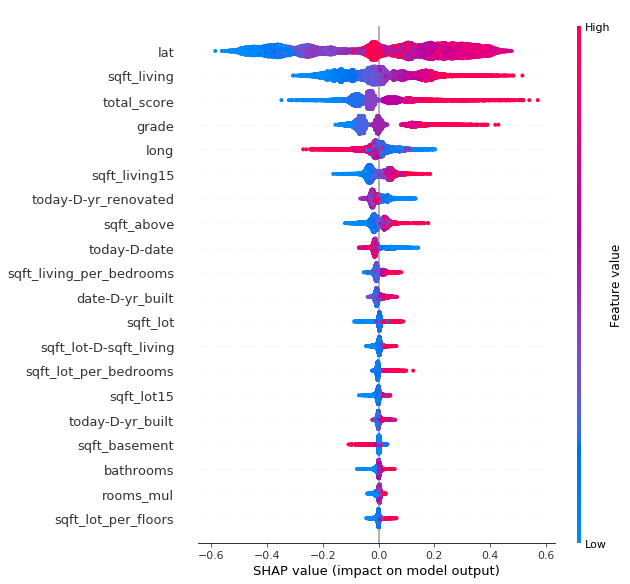

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
shap.summary_plot(shap_values, x_data)

In [14]:
for i in range(40, 90, 5):
    print(i, evaluate(data[shap_feat_imp.iloc[:i].index], data['price']))

40 -115393.6832243247
45 -114406.79545733507
50 -114198.24720690289
55 -114096.26432631556
60 -113960.06898229026
65 -113470.07357235393
70 -113597.63057095224
75 -114634.05866770144
80 -113103.90922226007
85 -113779.09199021169


# Combine

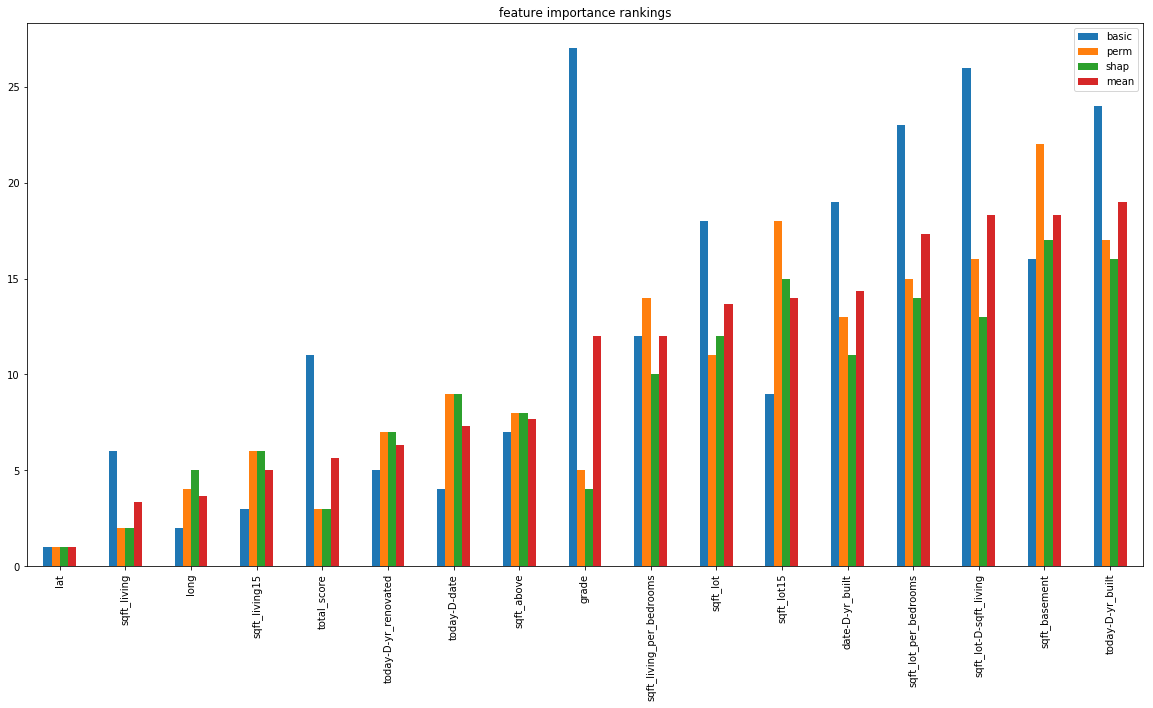

In [15]:
feat_imp_archive = pd.DataFrame(index=feats, columns=['basic', 'perm', 'shap', 'mean'])
feat_imp_archive['basic'] = feat_imp.rank(ascending=False)
feat_imp_archive['perm'] = perm_feat_imp.rank(ascending=False)
feat_imp_archive['shap'] = shap_feat_imp.rank(ascending=False)
feat_imp_archive['mean'] = feat_imp_archive[['basic', 'perm', 'shap']].mean(axis=1)
feat_imp_archive = feat_imp_archive.sort_values('mean')
feat_imp_archive[feat_imp_archive['mean']<20].plot(kind='bar', figsize=(20, 10), title='feature importance rankings');

In [16]:
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp_archive.iloc[:i].index], data['price']))

40 -115504.03706645542
45 -112793.3803917227
50 -113242.52854845773
55 -112082.29674764207
60 -113145.88623107321
65 -113493.26843290798
70 -114960.13218496056
75 -113766.97980934732
80 -112729.81508592931
85 -114212.27154476421


# Boruta

In [17]:
%%time
rf = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=0)
feat_selector.fit(data[feats].values, data['price'].values)

CPU times: user 1h 14min 39s, sys: 5.33 s, total: 1h 14min 45s
Wall time: 19min 20s


In [18]:
evaluate(data[np.array(feats)[feat_selector.support_]], data['price'])

-117993.25905640313

boruta를 사용했더니 confirm된 feature들이 너무 적어서 성능이 오히려 떨어지네요. 제가 잘못 사용한 것일수도?

# 결론

여러 feature selection 테크닉들을 알아봤습니다. 이 상황에서는 permutation importance with rfe에서 n_feats=80일 때가 -111049로 가장 점수가 높았습니다. baseline 점수인 -114196보다 3000가량 향상했네요.

물론 computational cost의 문제로 KFold가 아닌 단순 train-val set으로 검증했고, 각 모델 별로 hyperparameter tuning 또한 하지 않았기 때문에 정확한 비교는 아닙니다. 그래도 안하는 것보다는 나을 것이라고 믿는 정도겠습니다.

다른 데이터셋이거나 다른 feature engineering을 했을 경우 이 결과값은 또 달라질 수 있습니다. 여러 가지 feature selection 테크닉들을 사용해보고 가장 성능이 좋은 feature set을 선택하는 것이 좋을 것 같습니다.